In [2]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# Load Baseline InceptionV3 sweep from wandb
api = wandb.Api()
entity, project = "arnalytics-universitat-aut-noma-de-barcelona", "C6-Week1"

run_id = "kem0z7kj"

run = api.run(f"{entity}/{project}/{run_id}")
df = run.history()

In [14]:
df.columns

Index(['_step', '_runtime', 'train/loss', 'train/grad_norm',
       'train/learning_rate', 'train/epoch', '_timestamp', 'train/global_step',
       'loss', 'learning_rate', 'epoch', 'grad_norm', 'map_pedestrian',
       'mar_10', 'mar_medium', 'mar_100_pedestrian', 'map_small', 'map_75',
       'mar_100', 'map_50', 'map', 'map_car', 'mar_small', 'map_medium',
       'mar_100_car', 'mar_1', 'mar_large', 'map_large', 'eval/mar_10',
       'eval/map', 'eval/map_75', 'eval/mar_1', 'eval/mar_100_pedestrian',
       'eval/map_small', 'eval/mar_small', 'eval/loss', 'eval/mar_100_car',
       'eval/map_car', 'eval/map_50', 'eval/map_pedestrian',
       'eval/steps_per_second', 'eval/mar_medium', 'eval/samples_per_second',
       'eval/map_large', 'eval/mar_large', 'eval/runtime', 'eval/map_medium',
       'eval/mar_100', 'eval_map', 'eval_map_75', 'eval_map_medium',
       'eval_runtime', 'eval_map_small', 'eval_map_car',
       'eval_steps_per_second', 'eval_mar_small', 'eval_mar_100',
      

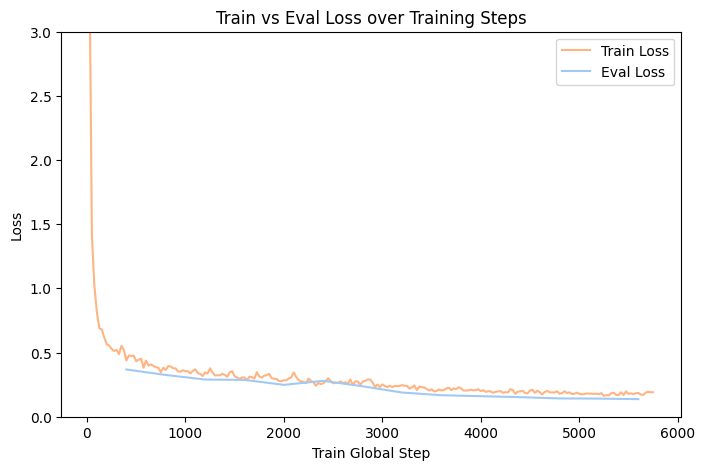

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define pastel colors
colors = sns.color_palette("pastel")

plt.figure(figsize=(8, 5))

# Plot Train Loss (Pastel Orange)
sns.lineplot(data=df, x='train/global_step', y='train/loss', color=colors[1], label='Train Loss')

# Plot Eval Loss (Pastel Blue)
sns.lineplot(data=df, x='train/global_step', y='eval_loss', color=colors[0], label='Eval Loss')

# Labels and title
plt.xlabel('Train Global Step')
plt.ylabel('Loss')
plt.title('Train vs Eval Loss over Training Steps')
# y axis between 0 and 3
plt.ylim(0, 3)
plt.legend()

plt.show()


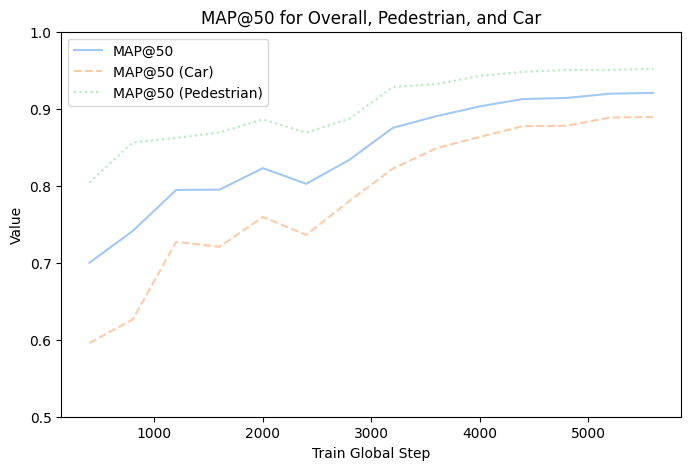

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define pastel colors
colors = sns.color_palette("pastel")

plt.figure(figsize=(8, 5))

# Plot MAP@50 (solid line)
sns.lineplot(data=df, x='train/global_step', y='map', color=colors[0], label='MAP@50')

# Plot MAP@50 (Car) - Dashed line, transparent
sns.lineplot(data=df, x='train/global_step', y='map_pedestrian', 
             color=colors[1], label='MAP@50 (Car)', linestyle='--', alpha=0.7)

# Plot MAP@50 (Pedestrian) - Dotted line, transparent
sns.lineplot(data=df, x='train/global_step', y='map_car', 
             color=colors[2], label='MAP@50 (Pedestrian)', linestyle=':', alpha=0.7)

# Labels and title
plt.xlabel('Train Global Step')
plt.ylabel('Value')
plt.title('MAP@50 for Overall, Pedestrian, and Car')
plt.ylim(0.5, 1)
plt.legend()

plt.show()


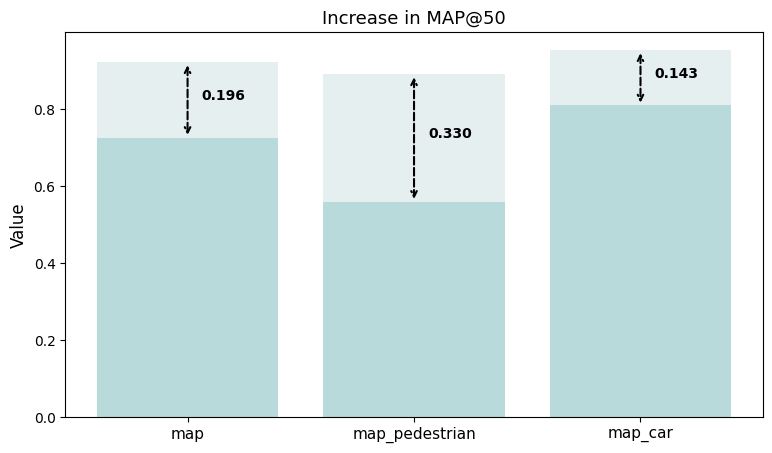

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `df` is your actual DataFrame
# Extract the last non-NaN value for each metric
final_values = df[['map', 'map_pedestrian', 'map_car']].ffill().iloc[-1]  # Forward fill and take last row

# Initial values
initial_values = pd.Series({'map': 0.725, 'map_pedestrian': 0.559, 'map_car': 0.809})

# Calculate increase
increase = final_values - initial_values

# Define pastel colors for the bars
initial_color = "#A8D1D1"  # Soft pastel blue
increase_color = "#DFEBEB"  # Soft pastel red for the increase

# Create bar plot
fig, ax = plt.subplots(figsize=(9, 5))
x_labels = ['map', 'map_pedestrian', 'map_car']
x = range(len(x_labels))

# Plot initial values in one pastel color
ax.bar(x, initial_values.values, label="Initial", alpha=0.8, color=initial_color)

# Plot increase in a different pastel color
ax.bar(x, increase.values, bottom=initial_values.values, label="Increase", alpha=0.8, color=increase_color)

# Add <--> dashed arrows and text
for i, (init, inc) in enumerate(zip(initial_values.values, increase.values)):
    final = init + inc
    mid = (init + final) / 2  # Midpoint for better alignment
    
    # Dashed double-headed arrow <-->
    ax.annotate("", xy=(i, init), xycoords='data',
                xytext=(i, final), textcoords='data',
                arrowprops=dict(arrowstyle='<->', linestyle='dashed', color='black', lw=1.5))
    
    # Text next to the arrow
    ax.annotate(f'{inc:.3f}', 
                xy=(i, mid), xycoords='data',  
                xytext=(10, 0), textcoords='offset points',  # Shift text slightly to the right
                ha='left', fontsize=10, fontweight='bold', color='black')

# Labels and legend
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=11)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Increase in MAP@50", fontsize=13)
# ax.legend()

plt.show()
